In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import time
from util.depth import *
from util.path import *
from util.visualizer import *
from util.object_dection import *
from util.selly_vision_api import *

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
       gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=500)])
    except RuntimeError as e:
        print(e)

#tensorrt model
loaded = tf.saved_model.load("./trt_fp16")
model = loaded.signatures["serving_default"]

data = np.load("video_data.npz")
data = data["arr_0"]

img = data[:,0,:,:,:]
point_cloud = data[:,1,:,:,:]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/hyeok/selly_vision/util/visualizer.py:202: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)


141


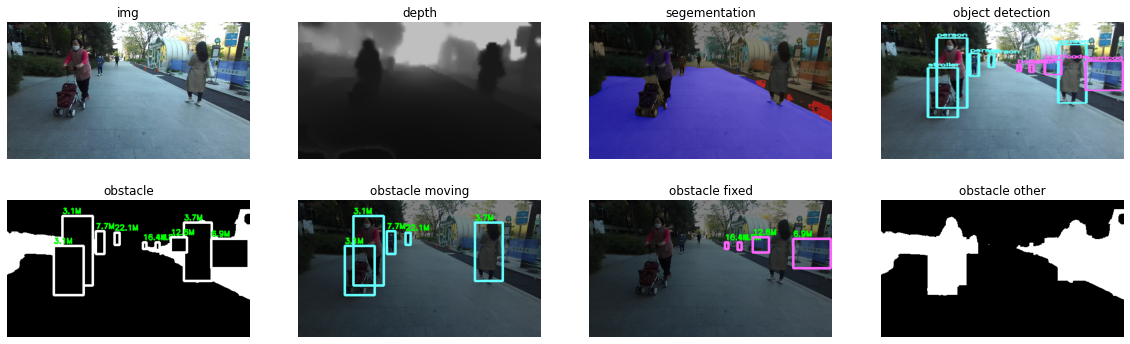

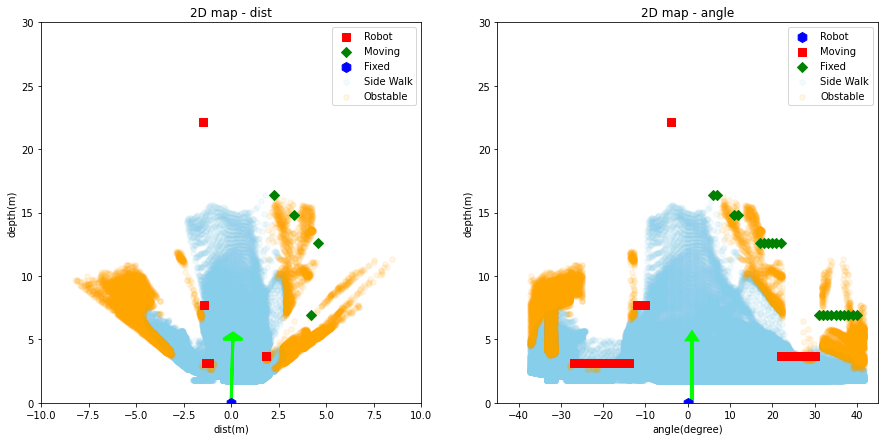

In [2]:
i=141
visualize(model, img[i], point_cloud[i], 25, 25, -2.5)
print(i)

In [40]:
def selly_vision_img(model, img, point_cloud, max_dist, fix_dist):
    only_sidewalk = seg_predict(img.copy(),model)
    obj_frame, moving_object, fixed_object  = YOLO(img.copy())
    point = point_cloud.copy()
    point[200 :,:, 2][(point[200 :,:, 2] >5) & (only_sidewalk[200:,:,0] !=0)] = np.mean(point[:,:, 2][(point[:,:, 2]<2)& (only_sidewalk[:,:,0] !=0)])
    point[200 :,:, 1][(point[200 :,:, 1] >3) & (only_sidewalk[200:,:,0] !=0)] = np.mean(point[:,:, 1][(point[:,:, 1]<3)& (only_sidewalk[:,:,0] !=0)])
    #point[200 :,:, 0][(point[200 :,:, 0] ==np.inf) | (np.abs(point[200 :,:, 0])>2)] = np.mean(point[200:,:, 0][point[200:,:, 0]<2])
    
    point[:,:, 2][point[:,:, 2]==np.inf] = 40
    only_sidewalk[(point[:,:,1] < -3) |  (point[:,:,1] ==np.inf)] = 0  #일정 높이 이상 segmetation 오차 제거

    depth = point2dist(point)
    obstacle = np.ones_like(img)
    obstacle[only_sidewalk!=0] = 0
    
    angle = point.copy()
    angle[angle[:, :,2]==np.inf]=1
    angle = np.arctan((angle[:, :,0]/angle[:,:,2]
                            ))/np.pi * 180
    angle = angle[:,:, np.newaxis]
    angle= np.concatenate((angle,angle,angle) , axis = 2)

    for i in range(480):   #연산 최적화 필요
        target = angle[:,i:i+1,:]
        angle_mean = np.mean(target[(target>-42) & (target<42)])
        target[np.abs(target - angle_mean)>3 ] = angle_mean
        
    moving_object_position, fixed_object_position =[] ,[]
    
    if len(moving_object):
        moving_object_position = object_angle(moving_object, angle.copy(), depth)
    if len(fixed_object):
        fixed_object_position = object_angle(fixed_object, angle.copy(), depth)
        
    for i in moving_object:
        obstacle[i[0][1] :i[1][1], i[0][0] : i[1][0], :] = 1
        
    for i in fixed_object:
        obstacle[i[0][1] :i[1][1], i[0][0] : i[1][0], :] = 1

    obstacle[(depth[:,:,0] > fix_dist) |(point[:,:,1] < -3) |  (point[:,:,1] ==np.inf)]=0 #일정 높이이상 장애물 제거
    obs_count={}
    oba = np.unique(np.round(angle[(obstacle!=0) & (obstacle<fix_dist)]), return_counts=True)
    for i, j in zip(oba[0],oba[1]):
        obs_count[i] = j
    for i in range(int(np.min(angle)), int(np.max(angle))):
        if not i in obs_count.keys():
            obs_count[i] = 0
      
    for i in moving_object_position:
        if i[2] < 7:
            for j in range(int(i[0]), int(i[1])+1, 1):
                if j in obs_count.keys():
                    obs_count[j] =9999
                    
    for i in fixed_object_position:
        if i[2] < 2:
            for j in range(int(i[0]), int(i[1])+1,1 ):
                if j in obs_count.keys():
                    obs_count[j] =9999
                    
    able_angle = sorted(obs_count.items(), key =  lambda x : (x[1], np.abs(x[1])))
    able_angle = np.array(able_angle)
    ang_dict = {}
    for i in able_angle[:,0]:
        value =np.round(np.mean(able_angle[:,1][(able_angle[:,0] >= -10+i) & (able_angle[:,0] <= +10+i)]))
        if value != np.nan:
            ang_dict[i] = value 
    able_angle = sorted(ang_dict.items(), key =  lambda x : (x[1], np.abs(x[0])))

    return  able_angle

In [41]:
i =150
st = time.time()
obs_angle = selly_vision_img(model, img[i], point_cloud[i], 25, 25)
print(obs_angle[0][0])
print(time.time() - st)

[(-2.0, 73.0), (-1.0, 92.0), (0.0, 108.0), (1.0, 129.0), (2.0, 148.0), (3.0, 165.0), (4.0, 186.0), (-3.0, 533.0), (5.0, 662.0), (-4.0, 996.0), (6.0, 1138.0), (-5.0, 1462.0), (7.0, 1614.0), (-6.0, 1928.0), (8.0, 2090.0), (34.0, 2294.0), (35.0, 2368.0), (-7.0, 2398.0), (-8.0, 2412.0), (-9.0, 2428.0), (36.0, 2438.0), (-10.0, 2452.0), (-11.0, 2473.0), (-12.0, 2500.0), (37.0, 2514.0), (-13.0, 2522.0), (-14.0, 2551.0), (9.0, 2566.0), (-15.0, 2584.0), (38.0, 2594.0), (-16.0, 2640.0), (33.0, 2679.0), (39.0, 2680.0), (40.0, 2755.0), (41.0, 2853.0), (42.0, 2941.0), (32.0, 3028.0), (10.0, 3042.0), (-17.0, 3115.0), (31.0, 3445.0), (11.0, 3519.0), (-18.0, 3588.0), (30.0, 3700.0), (29.0, 3965.0), (12.0, 3994.0), (-19.0, 4061.0), (28.0, 4277.0), (13.0, 4466.0), (14.0, 4508.0), (-20.0, 4536.0), (15.0, 4557.0), (16.0, 4606.0), (27.0, 4614.0), (17.0, 4658.0), (18.0, 4711.0), (19.0, 4776.0), (20.0, 4833.0), (21.0, 4906.0), (26.0, 4935.0), (22.0, 5007.0), (-21.0, 5013.0), (23.0, 5112.0), (24.0, 5196.0), (

In [291]:
import os
sight_list =os.listdir("sight")
sight_list.sort()
i=0
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('sight.mp4', fourcc, 10.0, (2160,720))
while i<len(sight_list)-2:
    st = time.time()
    img = cv2.imread("sight/"+sight_list[i+1])
    out.write(img)
    print(time.time() - st)
    i+=1
out.release()

0.04145050048828125
0.025942087173461914
0.02433609962463379
0.02414536476135254
0.024256467819213867
0.02442193031311035
0.024381399154663086
0.02422022819519043
0.024418354034423828
0.024190902709960938
0.02439260482788086
0.02441263198852539
0.025377511978149414
0.02431321144104004
0.024089574813842773
0.02403736114501953
0.02403116226196289
0.02420210838317871
0.024307966232299805
0.02425241470336914
0.02430129051208496
0.02427816390991211
0.02411055564880371
0.024143218994140625
0.025564193725585938
0.024376630783081055
0.024253129959106445
0.024506092071533203
0.024331331253051758
0.024158716201782227
0.024013519287109375
0.024274826049804688
0.024123430252075195
0.02446126937866211
0.024236202239990234
0.024268150329589844
0.02519536018371582
0.02400684356689453
0.024106979370117188
0.024413585662841797
0.024142742156982422
0.0241239070892334
0.024019241333007812
0.024045467376708984
0.023876667022705078
0.023828744888305664
0.02384185791015625
0.023984909057617188
0.02519702911

KeyboardInterrupt: 